In [70]:
'''
    Author - Oyesh Mann Singh
    Date - 11/05/2018
    Description 
        - Nepali News Classification
        - Analyzing various ML algorithms
'''

import os
import sys
import time
import re
import string
import unicodecsv as csv
import unicodedata as un
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

import pickle

In [2]:
# Reading train/text files
pd_train = pd.read_csv('./data/raw/train.csv')
pd_test = pd.read_csv('./data/raw/test.csv')

In [3]:
classes = ['Auto', 'Bank', 'Blog', 'Business Interview',
           'Economy', 'Education', 'Employment', 'Entertainment',
           'Interview', 'Literature', 'National News', 'Opinion',
           'Sports', 'Technology', 'Tourism', 'World']

In [4]:
pd_train.shape

(10594, 2)

In [5]:
pd_train.head()

,label,data
0,10,थारु सभासदहरुले कैलालीको टीकापुरमा भएको झडपमा ...
1,10,राजविराज चैत सप्तरी प्रहरीले पातो गाविसबाट स...
2,1,गजेन्द्र बुढाथोकीकाठमाडौं माघ बैंकिङ क्षेत्र...
3,10,उपप्रधानमन्त्री कमल थापाले संविधानमा असहमति हु...
4,10,असोज काठमाडौं अमेरिकी अधिकारीहरुले आधिकारिक ...


In [6]:
pd_train.label.unique()

array([10,  1,  7, 12,  3,  2, 11, 15,  4, 14,  0,  6,  8, 13,  5,  9])

In [7]:
# Check the number of records for each label
pd_train.groupby('label').count()

,data
label,
0,68
1,270
2,161
3,108
4,878
5,65
6,108
7,881
8,65


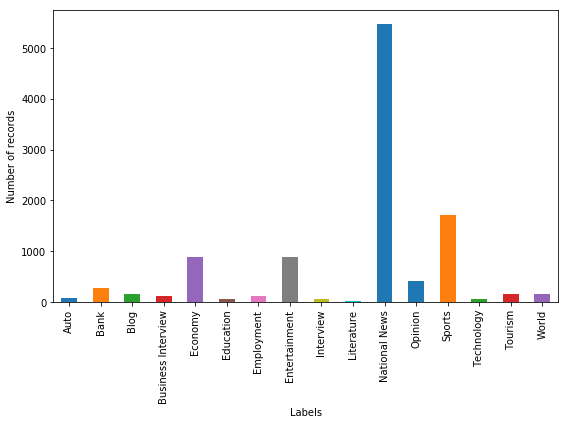

In [8]:
'''
    Total number of positive/negative
'''
import matplotlib.pyplot as plt

def histogram_by_label(train_set):
    fig, ax = plt.subplots(figsize=(8,6))

    train_set.groupby('label').data.count().plot.bar(ylim=0)

    ax.set_xticklabels(classes, rotation=90)
    ax.set_ylabel('Number of records')
    ax.set_xlabel('Labels')
    fig.tight_layout()
    plt.show()

histogram_by_label(pd_train)

In [9]:
pd_train_1 = pd_train[(pd_train.label != 10) & (pd_train.label != 12) & (pd_train.label != 4) & (pd_train.label != 7)]

In [10]:
pd_train_1.groupby('label').count()

,data
label,
0,68
1,270
2,161
3,108
5,65
6,108
8,65
9,13
11,419


In [11]:
pd_train_1 = pd_train_1.append(pd_train.loc[pd_train.label == 10][:400])
pd_train_1 = pd_train_1.append(pd_train.loc[pd_train.label == 12][:400])
pd_train_1 = pd_train_1.append(pd_train.loc[pd_train.label == 4][:400])
pd_train_1 = pd_train_1.append(pd_train.loc[pd_train.label == 7][:400])

In [12]:
pd_train_1.groupby('label').count()

,data
label,
0,68
1,270
2,161
3,108
4,400
5,65
6,108
7,400
8,65


# BALANCE THE DATASET

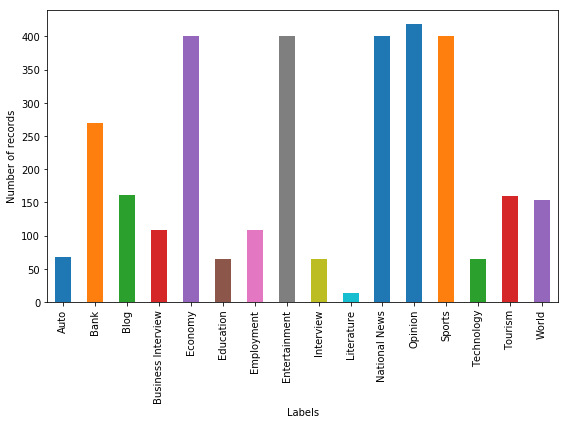

In [13]:
histogram_by_label(pd_train_1)

In [14]:
pd_train = pd_train_1

In [15]:
train_token_count = 0
test_token_count = 0

for each_row in pd_train['data']:
    train_token_count += len(each_row)
    
for each_row in pd_test['data']:
    test_token_count += len(each_row)

print("Number of tokens in train = ", train_token_count)
print("Number of tokens in test = ", test_token_count)

Number of tokens in train =  8122101
Number of tokens in test =  6874718


In [16]:
print("Avg Number of tokens in each sentence in train = ", train_token_count/pd_train.shape[0])
print("Avg Number of tokens in each sentence in test = ", test_token_count/pd_test.shape[0])

Avg Number of tokens in each sentence in train =  2495.269124423963
Avg Number of tokens in each sentence in test =  1946.9606343811952


In [17]:
from nltk.util import ngrams
from collections import Counter

# Putting all data into a list
train_tokens_list = pd_train.data.tolist()
test_tokens_list = pd_test.data.tolist()

In [18]:
# Testing if the token_list can be easily tokenized
train_tokens_list[10].split()[5]

'पछिल्लो'

In [19]:
# Testing if the token_list can be easily tokenized
test_tokens_list[10].split()[5]

'प्रचण्डले'

In [20]:
tokens = []
for each in train_tokens_list:
    for i in each.split():
        tokens.append(i)

In [21]:
# Checking the most commong trigrams
text_trigrams = ngrams(tokens, 3)

Counter(text_trigrams).most_common(10)

[(('बैंक', 'तथा', 'वित्तीय'), 201),
 (('गर्ने', 'हो', 'भने'), 142),
 (('हुन', 'सकेको', 'छैन'), 131),
 (('करोड', 'लाख', 'हजार'), 131),
 (('गर्दै', 'आएको', 'छ'), 125),
 (('प्रमुख', 'कार्यकारी', 'अधिकृत'), 124),
 (('करोड', 'लाख', 'रुपैयाँ'), 118),
 (('उनको', 'भनाइ', 'छ'), 117),
 (('अर्ब', 'करोड', 'रुपैयाँ'), 115),
 (('अर्ब', 'करोड', 'लाख'), 115)]

In [22]:
# Checking the most commong bigrams
text_trigrams = ngrams(tokens, 2)

Counter(text_trigrams).most_common(10)

[(('भएको', 'छ'), 1913),
 (('गरेको', 'छ'), 1663),
 (('गरेका', 'छन्'), 1016),
 (('छ', 'तर'), 800),
 (('हो', 'भने'), 760),
 (('गरिएको', 'छ'), 735),
 (('भए', 'पनि'), 634),
 (('जनाएको', 'छ'), 633),
 (('छ', 'यो'), 625),
 (('आएको', 'छ'), 615)]

In [23]:
# Checking the most commong trigrams
text_unigram = ngrams(tokens, 1)

c = Counter(text_unigram)

c.most_common(10)

[(('छ',), 22632),
 (('र',), 22288),
 (('पनि',), 15142),
 (('हो',), 8650),
 (('छन्',), 7725),
 (('भने',), 6570),
 (('भएको',), 6545),
 (('लागि',), 6419),
 (('गर्न',), 6279),
 (('गर्ने',), 6034)]

In [24]:
# Get total count of unique words
print('Total count of unique tokens = ', len(c))

Total count of unique tokens =  124646


In [25]:
from nltk import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a tokenizer
tokenizer = TweetTokenizer()

In [26]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)

In [27]:
# Merge train and test list
full_text = train_tokens_list + test_tokens_list

In [28]:
unique_count = Counter(full_text)

In [29]:
%%time
vectorizer.fit(full_text)

CPU times: user 30.2 s, sys: 16 ms, total: 30.2 s
Wall time: 30.2 s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x3ffd216009b0>>,
        use_idf=True, vocabulary=None)

In [30]:
len(vectorizer.get_feature_names())

127113

In [31]:
print(vectorizer.get_feature_names()[1:10])

['à ààà', 'àªààà', 'àªààà àààªà', 'àªààà àšààà', 'àªàààµàà', 'àªàààµàà àààœàà', 'àµààà', 'àµààà ààà', 'àµàààµààà']


In [32]:
# Shuffle the data
pd_train = pd_train.sample(frac=1).reset_index(drop=True)
pd_test = pd_test.sample(frac=1).reset_index(drop=True)

In [33]:
# Check the data after shuffled
pd_train.head()

,label,data
0,6,वैशाख काठमाडौं सरकारले वैदेशिक रोजगारीमा रहे...
1,12,काठमाडौं अन्तर्राष्ट्रिय एकदिवशीय खेलमा सचिन ...
2,10,काडमाडौँ चैत काठमाडौंको गोलढुंगास्थित पासाङल...
3,6,वैशाख काठमाडौं वैदेशिक रोजगारमा जाने कामदारक...
4,7,चलचित्र वितरक तथा हल संचालक गोपाल कायस्थले नाय...


In [34]:
# Transform our input train/test data
train_vectorized = vectorizer.transform(pd_train.data)
test_vectorized = vectorizer.transform(pd_test.data)

In [35]:
# Check the shape of transformed vector
print(train_vectorized.shape)

(3255, 127113)


In [ ]:
# Testing with random new review
review = ["सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।",
         "आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।",
         "बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। "]

# Print the prediction of new reviews
def print_prediction(review, est):
    print("*****EVALUATE REVIEW*******")
    review_vectorized = vectorizer.transform(review)
    y_pred = est.predict(review_vectorized)
    for each_review, each_y_pred in zip(review, y_pred):
        print("{0}: {1}".format(each_review, classes[each_y_pred]))
        
        
def print_acc(est, acc):
    print("Accuracy of {0}: {1:2.3%}".format(est, acc))
    
    
# Compute ROC curve and ROC area for each class
def draw_roc_auc_curve(y_test, y_pred, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test[:], y_pred[:])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr['micro'], tpr['micro'], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc['micro'])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + title)
    plt.legend(loc="lower right")
    plt.show()
    

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    
    

## ACCURACY, PRECISION, RECALL

In [41]:
'''
    Input : predicted and ground_truth labels
    Output : accuracy, precision, recal, and list of TP, FP, FN, TN
'''
def calc_acc_prec_recall(pred, gt):
    true_pos = 0
    false_pos = 0
    false_neg = 0
    true_neg = 0
    acc = 0
    
    for y_pred, y_gt in zip(pred, gt):
        if y_pred == y_gt:
            acc += 1
            
        if y_pred == y_gt and y_gt == 1 and y_pred == 1:
            true_pos += 1
            
        if y_pred != y_gt and y_gt == 2 and y_pred == 1:
            false_pos += 1   
            
        if y_pred != y_gt and y_gt == 1 and y_pred == 2:
            false_neg += 1      

        if y_pred == y_gt and y_gt == 2 and y_pred == 2:
            true_neg += 1                
    
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    total_acc = acc / len(gt)
    
    print('Accuracy:', total_acc)
    print('Precision:', precision)
    print('Recall:', recall)
    
    print('Number of True Positive:', true_pos)
    print('Number of False Positive:', false_pos)
    print('Number of False Negative:', false_neg)
    print('Number of True Negative:', true_neg)
    
    val = [true_pos, false_pos, false_neg, true_neg]
    
    return total_acc, precision, recall, val

## CONFUSION MATRIX

In [61]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
def display_confusion_mat(y_pred, gt):
    cnf_matrix = confusion_matrix(gt, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(20,10))
    plot_confusion_matrix(cnf_matrix, classes=classes,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure(figsize=(20,10))
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                          title='Normalized confusion matrix')

# MACHINE LEARNING SECTION STARTS

In [37]:
%%time
'''
    Logistic Regression
'''
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

logreg = LogisticRegression()
ovr = OneVsRestClassifier(logreg)

ovr.fit(train_vectorized, pd_train.label.values)
ovr_acc = ovr.score(test_vectorized, pd_test.label.values)

print("One vs Rest Logisitic Regression accuracy = ", ovr_acc)

One vs Rest Logisitic Regression accuracy =  0.6864910790144435
CPU times: user 6min 5s, sys: 1.22 s, total: 6min 6s
Wall time: 10.6 s


In [38]:
y_pred = ovr.predict(test_vectorized)

In [39]:
y_test = pd_test.label.values

In [42]:
print_prediction(review, ovr)

*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: National News
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Sports
बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Sports


In [44]:
# %%time
# from yellowbrick.text import TSNEVisualizer

# # Create the visualizer and draw the vectors
# tsne = TSNEVisualizer()
# tsne.fit(train_vectorized[0:500], pd_train.label[0:500])
# tsne.poof()
# # print("Label 1= Negative and Label 2 = Positive")

Confusion matrix, without normalization
Normalized confusion matrix


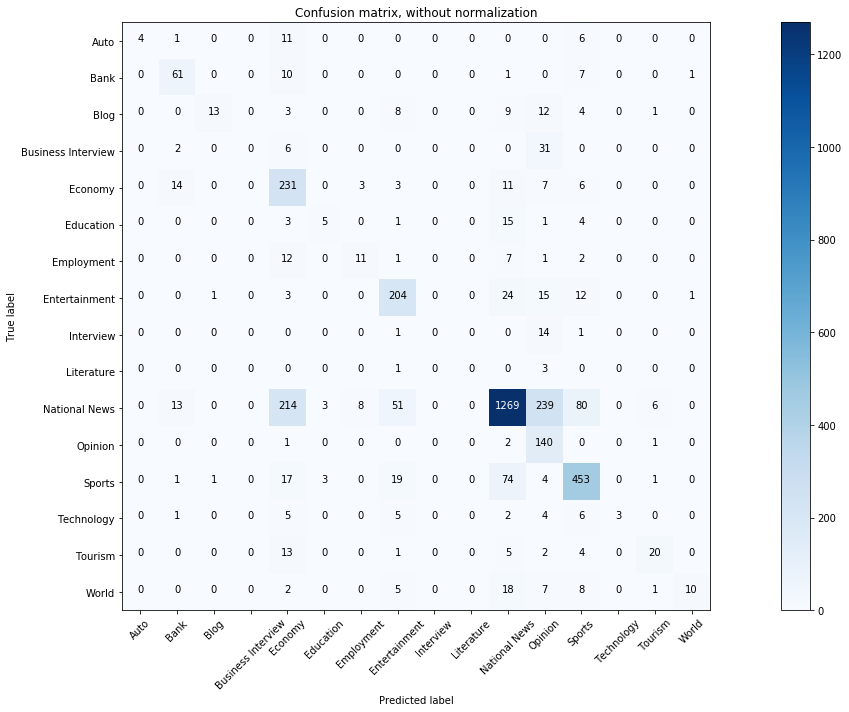

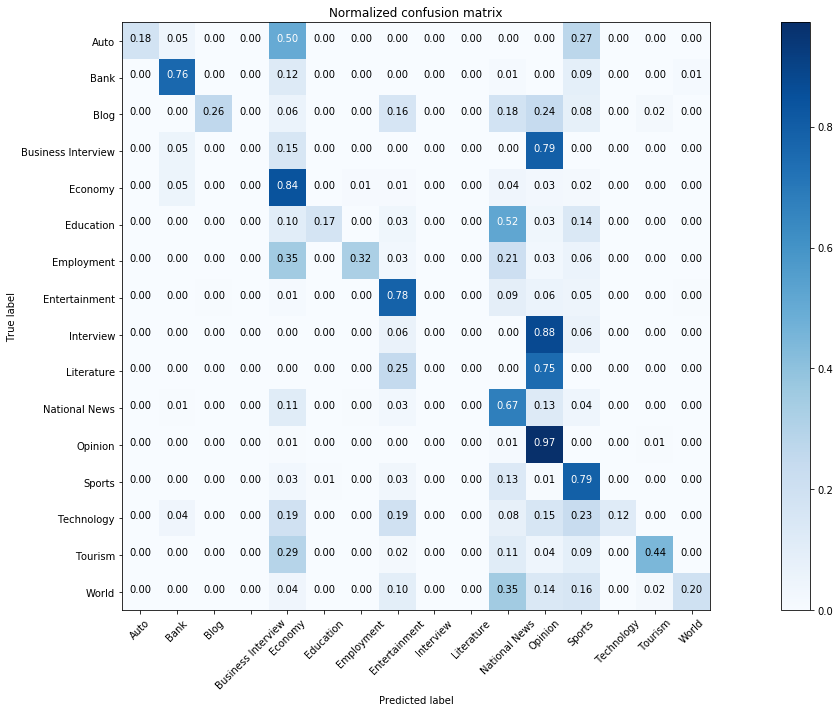

In [63]:
display_confusion_mat(y_pred=y_pred, gt=pd_test.label)

In [65]:
acc, prec, recall, val = calc_acc_prec_recall(y_pred, pd_test.label)
print(val)

Accuracy: 0.6864910790144435
Precision: 1.0
Recall: 1.0
Number of True Positive: 61
Number of False Positive: 0
Number of False Negative: 0
Number of True Negative: 13
[61, 0, 0, 13]


In [ ]:
%%time
'''
    Cross Validation Logistic Regression
'''
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np

cv_ovr = LogisticRegression()

cv_ovr = cross_validate(cv_ovr, train_vectorized, pd_train.label.values, scoring='accuracy', n_jobs=4, cv=5)

In [35]:
print(cv_ovr['test_score'])

[0.8768 0.8872 0.8908 0.8928 0.894  0.886  0.8932 0.8904 0.8828 0.894 ]


In [36]:
print('Cross-validation mean (test) accuracy {0:.2f}%, std {1:.2f}.'.format(np.mean(cv_ovr['test_score']) * 100, np.std(cv_ovr['test_score']) * 100))

Cross-validation mean (test) accuracy 88.88%, std 0.54.


In [92]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

ovr = LogisticRegression()

param_grid = {'C': [1, 10, 100, 1000] }

ovr_grid = GridSearchCV(ovr, param_grid=param_grid, cv=5, refit=True, verbose=1)

ovr_grid_fit = ovr_grid.fit(train_vectorized, pd_train.label.values)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.9min finished


Wall time: 5min 16s


In [95]:
ovr_grid_score = ovr_grid_fit.score(test_vectorized, pd_test.label.values)
print_acc(acc=ovr_grid_score, est='Logistic Regression CV')

Accuracy of Logistic Regression CV: 90.384%


In [96]:
# Testing with random new review
print_prediction(review, ovr_grid_fit)

Movie was good: Positive
There was normal acting: Negative


In [38]:
%%time
'''
    SVM
'''

from sklearn.svm import SVC

my_svm = SVC()

my_svm.fit(train_vectorized, pd_train.label.values)

svm_acc = my_svm.score(test_vectorized, pd_test.label.values)
print('SVM accuracy', svm_acc)

SVM accuracy 0.6966
Wall time: 1h 2min 31s


In [39]:
'''
    SVM accuracy 0.6966
    Wall time: 1h 2min 31s
'''

# Evaluate the trained algorithm with new data
print_prediction(review, my_svm)

This movie is fine: Positive
The movie is not fine: Positive


In [ ]:
%%time
'''
    Grid Search CV SVM
'''
from sklearn.model_selection import GridSearchCV

svm_grid = SVC()

param_grid = {'C': [1, 10, 100, 1000], 'gamma': [1e-3, 1e-4]}

svm_grid = GridSearchCV(svm_grid, param_grid=param_grid, cv=5, refit=True, verbose=1)

svm_grid_fit = svm_grid.fit(train_vectorized, pd_train.label.values)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [49]:
%%time
'''
    Naive Bayes MultinomialNB
'''

from sklearn.naive_bayes import MultinomialNB, BernoulliNB 

nb_clf = MultinomialNB()
nb_clf.fit(X=train_vectorized, y=pd_train.label.values)
nb_score = nb_clf.score(test_vectorized, pd_test.label.values)

print_acc('MultinomialNB', nb_score)

review = ['Movie was good', 'There was normal acting']
print_prediction(review, nb_clf)

Accuracy of MultinomialNB: 86.336%
*****EVALUATE REVIEW*******
Movie was good: Negative
There was normal acting: Negative
Wall time: 641 ms


In [50]:
%%time
'''
    Naive Bayes BernoulliNB
'''

nb_bern_clf = BernoulliNB()
nb_bern_clf.fit(X=train_vectorized, y=pd_train.label.values)
nb_bern_score = nb_bern_clf.score(test_vectorized, pd_test.label.values)

print_acc('MultinomialNB', nb_bern_score)

print_prediction(review, nb_bern_clf)

Accuracy of MultinomialNB: 85.084%
*****EVALUATE REVIEW*******
Movie was good: Negative
There was normal acting: Negative
Wall time: 1.19 s


In [97]:
%%time
'''
    KNN Classifier
'''

from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X=train_vectorized, y=pd_train.label.values)
knn_score = knn_clf.score(test_vectorized, pd_test.label.values)

print_acc('KNN Classifier', knn_score)

print_prediction(review, knn_clf)

Accuracy of KNN Classifier: 68.012%
Movie was good: Positive
There was normal acting: Negative
Wall time: 5min 32s


In [50]:
%%time
'''
    Grid Search CV kNN Classifier
'''
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_clf_grid = KNeighborsClassifier()

param_grid = {'n_neighbors': [1, 2, 3, 5, 10]}

knn_clf_grid = GridSearchCV(knn_clf_grid, param_grid=param_grid, cv=5, refit=True, verbose=1)

knn_grid_fit = knn_clf_grid.fit(train_vectorized, pd_train.label.values)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/oyashi/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 24min 1s, sys: 1min 8s, total: 25min 10s
Wall time: 24min 15s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 24.3min finished


In [108]:
print_acc(acc=knn_grid_fit.best_score_, est='GridSearch kNN')

review = ['He watched a movie', 'He was awarded for that kind of acting']
print_prediction(review, knn_grid_fit.best_estimator_)

Accuracy of GridSearch kNN: 74.669%
*****EVALUATE REVIEW*******
He watched a movie: Negative
He was awarded for that kind of acting: Positive


In [70]:
%%time
'''
    Perceptron
'''

from sklearn.linear_model import Perceptron

percept = Perceptron(tol=1e-3, random_state=0)
percept.fit(X=train_vectorized, y=pd_train.label.values)
percept_score = percept.score(test_vectorized, pd_test.label.values)

print_acc('Perceptron Classifier', percept_score)

Accuracy of Perceptron Classifier: 88.648%
Wall time: 1.08 s


In [72]:
percept_predict = percept.predict(test_vectorized)

In [40]:
review = ['He watched a good movie', 'nothing is good']
print_prediction(review, percept)

*****EVALUATE REVIEW*******
He watched a good movie: Negative
nothing is good: Negative


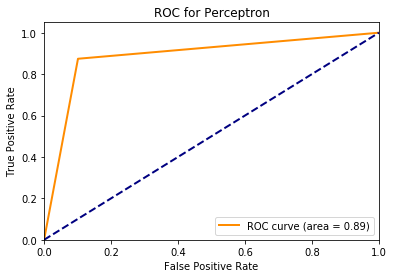

In [74]:
draw_roc_auc_curve(y_test=pd_test.label.values, y_pred=percept_predict, title='Perceptron')

In [97]:
%%time
'''
    Grid Search CV Perceptron
'''
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Perceptron

percept_grid = Perceptron()

param_grid = {'alpha':[0.0001, 0.001, 0.01, 0.1],'max_iter': [10, 50, 100, 200]}

percept_grid = GridSearchCV(percept_grid, param_grid=param_grid, cv=5, refit=True, verbose=1)

percept_grid_fit = percept_grid.fit(train_vectorized, pd_train.label.values)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/oyashi/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 16.6min finished


CPU times: user 17min 39s, sys: 2.45 s, total: 17min 41s
Wall time: 16min 45s


In [107]:
print_acc('GridSearch CV Perceptron Classifier', percept_grid_fit.best_score_)

review = ['He watched a good movie', 'The hall seats were empty']
print_prediction(review, percept_grid_fit.best_estimator_)

Accuracy of GridSearch CV Perceptron Classifier: 88.984%
*****EVALUATE REVIEW*******
He watched a good movie: Positive
The hall seats were empty: Negative


In [51]:
%%time
'''
    Multi Layered Perceptron - lbfgs
'''

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(X=train_vectorized, y=pd_train.label.values)
mlp_score = mlp.score(test_vectorized, pd_test.label.values)

print_acc('MultiLayered Perceptron Classifier', mlp_score)

Accuracy of MultiLayered Perceptron Classifier: 89.840%
Wall time: 3min 58s


In [61]:
review = ['He watched a stupid movie', '']
print_prediction(review, mlp)

*****EVALUATE REVIEW*******
He watched a stupid movie: Negative
hall was not: Positive


In [62]:
%%time
'''
    Multi Layered Perceptron - sgd
'''

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(X=train_vectorized, y=pd_train.label.values)
mlp_score = mlp.score(test_vectorized, pd_test.label.values)

print_acc('MultiLayered Perceptron Classifier', mlp_score)

Accuracy of MultiLayered Perceptron Classifier: 53.448%
Wall time: 10min 32s


In [70]:
review = ['He watched a good movie', 'what a flop movie']
print_prediction(review, mlp)

*****EVALUATE REVIEW*******
He watched a good movie: Positive
what a flop movie: Positive


In [ ]:
%%time
'''
    Multi Layered Perceptron - adam
'''

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(X=train_vectorized, y=pd_train.label.values)
mlp_score = mlp.score(test_vectorized, pd_test.label.values)

print_acc('MultiLayered Perceptron Classifier', mlp_score)

In [ ]:
%%time
'''
    Grid Search CV Multi Layered Perceptron
'''
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

mlp_grid = MLPClassifier(alpha=1e-5, random_state=1, hidden_layer_sizes=(10,5))

param_grid = {'solver':['lbfgs', 'sgd', 'adam']}

mlp_grid = GridSearchCV(mlp_grid, param_grid=param_grid, cv=5, refit=True, verbose=1)

mlp_grid_fit = mlp_grid.fit(train_vectorized, pd_train.label.values)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
print_acc('Grid Search CV Multi Layered Perceptron', mlp_grid_fit.best_score_)

In [27]:
%%time
'''
    Gradient Boosting Classifier
    
    # Didn't run this
    # It took lot of time
'''

from sklearn.ensemble import GradientBoostingClassifier

grad_boost = GradientBoostingClassifier()

grad_boost.fit(train_vectorized, pd_train.label.values)

grad_boost_score = grad_boost.score(test_vectorized, pd_test.label.values)

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 47.6 ms


In [32]:
%%time
'''
    Decision Tree
    
    NOTE: Decision Trees/Random Forest suffer badly in very high dimensional feature spaces. 
'''

from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()

# decision_tree.fit(train_vectorized, pd_train.label.values)

# decision_tree_score = decision_tree.score(test_vectorized, pd_test.label.values)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 30.5 µs


# VISUALIZATION SECTION STARTS

In [16]:
%%time
'''
    Collocate Cloud Visualization
'''

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=480, height=240, margin=0).generate(str(train_tokens_list))

Wall time: 33.1 s


In [22]:
def draw_cloud(word_cloud, title):
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.margins(x=0, y=0)
    plt.show()

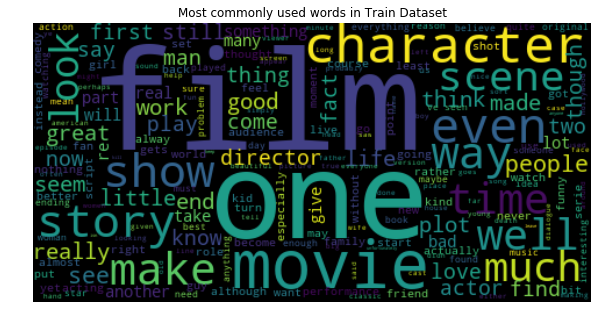

In [23]:
draw_cloud(wordcloud, title="Most commonly used words in Train Dataset")

In [24]:
wordcloud_test = WordCloud(width=480, height=240, margin=0).generate(str(test_tokens_list))

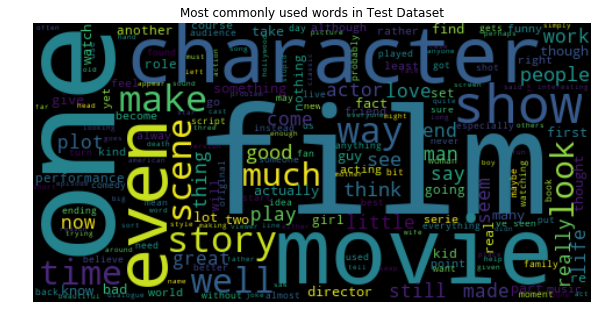

In [25]:
draw_cloud(wordcloud_test, title="Most commonly used words in Test Dataset")

In [97]:
'''
    Top 100 words
'''

# Creating stop words
text_unigram = ngrams(tokens, 1)

# Most common 50 words
stop_words = Counter(text_unigram).most_common(50)

stop_word_list = []
for item in stop_words:
    stop_word_list += item[0]

print(stop_word_list)

In [103]:
# Removed the words present in stop_word_list
filtered_tokens = [w for w in tokens if not w in stop_word_list] 

In [160]:
# Created unigram
filtered_text_unigram = ngrams(filtered_tokens, 1)

# Create counter
text_uni = Counter(filtered_text_unigram).most_common(100)

In [161]:
# Created dictionary for top 100 words
uni_dict = {}
for each in text_uni:
    uni_dict[each[0][0]] = each[1]

In [162]:
# Created word cloud for top 100 words
top_word_cloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(uni_dict)

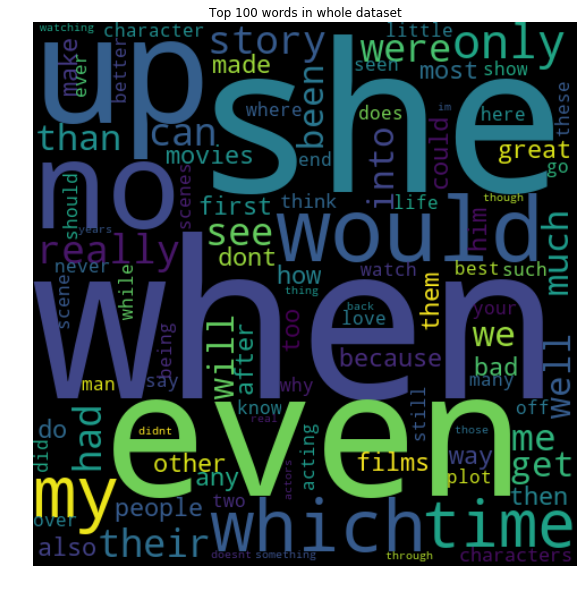

In [163]:
draw_cloud(top_word_cloud, title="Top 100 words in whole dataset")

In [155]:
# Created unigram
filtered_text_unigram = ngrams(filtered_tokens, 1)

# Create counter for least commonly used words
text_uni_least = Counter(filtered_text_unigram).most_common()[-100:]

In [156]:
# Created dictionary for least 100 words
uni_dict_least = {}
for each in text_uni_least:
    uni_dict_least[each[0][0]] = each[1]

In [157]:
# Created word cloud for least 100 words
least_word_cloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(uni_dict_least)

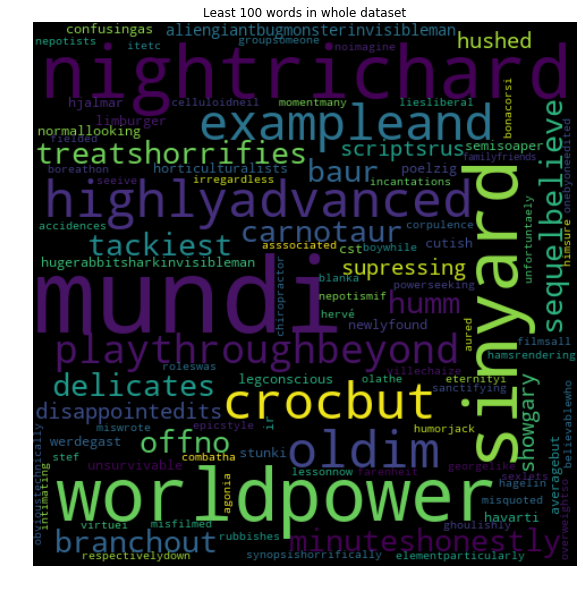

In [158]:
draw_cloud(least_word_cloud, title="Least 100 words in whole dataset")

In [170]:
'''
    Top words for bigrams
'''

# Creating stop words
text_bigram = ngrams(tokens, 2)

# Create counter
text_bi = Counter(text_bigram).most_common(100)

In [180]:
# Created dictionary for top 100 bigrams
bi_dict = {}
for each in text_bi:
    # Merge bigram words
    merged = each[0][0] + ' ' + each[0][1]
    bi_dict[merged] = each[1]

In [182]:
# Created word cloud for top 100 bigrams
bigram_cloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(bi_dict)

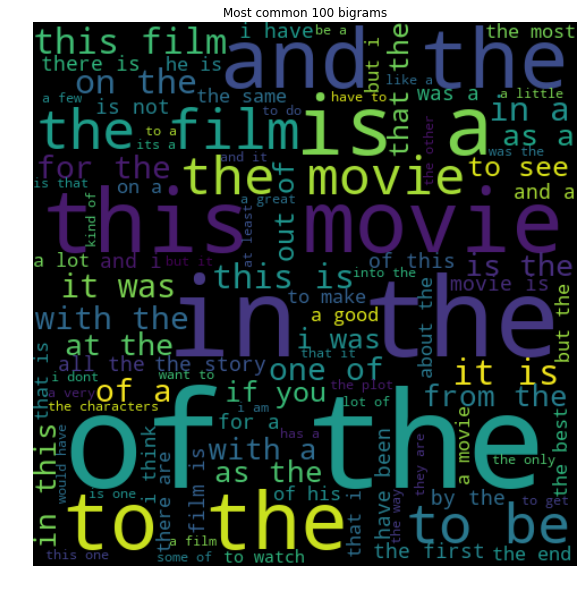

In [183]:
draw_cloud(bigram_cloud, title="Most common 100 bigrams")

In [184]:
'''
    Top words for Trigrams
'''

# Creating stop words
text_trigram = ngrams(tokens, 3)

# Create counter
text_tri = Counter(text_trigram).most_common(100)

In [186]:
# Created dictionary for top 100 bigrams
tri_dict = {}
for each in text_tri:
    # Merge trigram words
    merged = each[0][0] + ' ' + each[0][1] + ' ' + each[0][2]
    tri_dict[merged] = each[1]

In [187]:
# Created word cloud for top 100 bigrams
trigram_cloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(tri_dict)

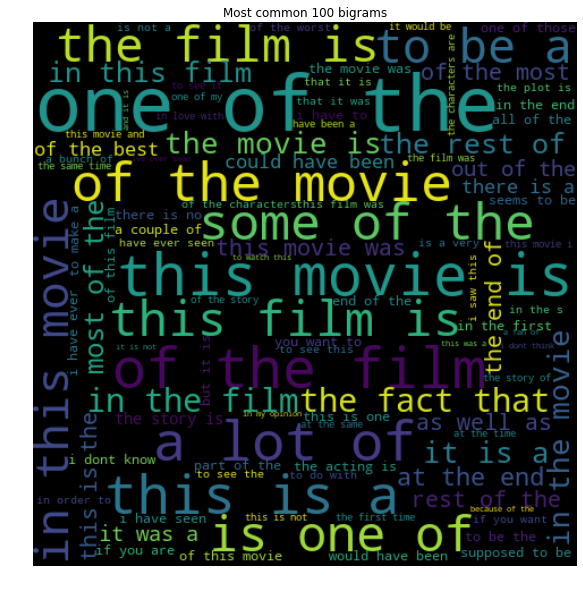

In [188]:
draw_cloud(trigram_cloud, title="Most common 100 bigrams")

['a' 'f']


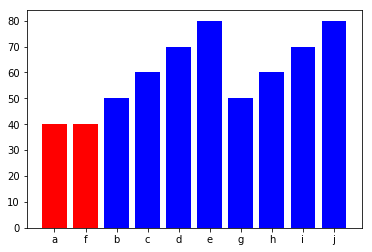

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# x = np.arange(10)
x = ['a','b','c','d','e','f','g', 'h','i','j']
y = [40, 50, 60, 70, 80, 40, 50, 60, 70, 80]

y = np.asarray(y)
x = np.asarray(x)

mask1 = y < 50
mask2 = y >= 50

plt.bar(x[mask1],y[mask1], color = 'red')
plt.bar(x[mask2],y[mask2], color = 'blue')
plt.show()